# Neural Net

We will train a neural network to do sentiment analysis. We will test which hyper-parameters and which encoding gives us the best results.

In [49]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from sklearn.metrics import confusion_matrix

## Preprocessing Data

In [2]:
#Import the data
df_train = pd.read_csv('../kaggle-competition-2/train_data.csv')
df_test = pd.read_csv('../kaggle-competition-2/test_data.csv')
df_train_labels = pd.read_csv('../kaggle-competition-2/train_results.csv')

In [3]:
#We want to remove neutral class since there are very few of them and then we can have a binary classification model
print(str(len(df_train_labels.loc[df_train_labels['target']=='neutral','target'])/len(df_train_labels)*100)+'%')
df_train_labels = df_train_labels[df_train_labels['target']!='neutral']
df_train = df_train.iloc[df_train_labels.index,:]

0.008074415349848076%


In [4]:
#Rename the labels
df_train_labels.loc[df_train_labels['target']=='negative','target'] = 0
df_train_labels.loc[df_train_labels['target']=='positive','target'] = 1

In [5]:
def preprocessing(df):
    sentences = df.copy()
    # Converting all the upper case to lower case to avoid the distinction between them
    sentences['text'] = df['text'].str.lower()
    # Putting the regex for removing the https and www URLs
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

    # Remove the video and links
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'{link}', '', x))
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"\[video\]", '', x))

    # Remove html reference characters
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

    # Remove usernames
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'@[^\s]+', '', x))

    # Removing numbers
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'\d+', '', x))

    # Removing hashmarks, non-letter characters
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

    # Removing all extra same letters to a limit of 2, ex. daaaang => daang, nooooooo => noo
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"(.)\1+", r"\1\1", x))
        
    return sentences

In [6]:
#Preprocess the senteces 
train_proc = preprocessing(df_train)
test_proc = preprocessing(df_test)
train_proc['text'] = train_proc['text'].apply(lambda x: x.split(' '))
test_proc['text'] = test_proc['text'].apply(lambda x: x.split(' '))

In [7]:
#Get the minium and maximum number of words for each text
print(max(max(train_proc['text'].apply(lambda x: len(x))),max(test_proc['text'].apply(lambda x: len(x)))))
print(min(min(train_proc['text'].apply(lambda x: len(x))),min(test_proc['text'].apply(lambda x: len(x)))))

62
2


In [8]:
#Load the encoders
word2vec_CBOW_100d = Word2Vec.load('../Encoders/word2vec_CBOW_100d')
word2vec_SkipGram_100d = Word2Vec.load('../Encoders/word2vec_SkipGram_100d')

In [9]:
#Functions to apply the word2vec encodinng to each word
def applyWord2VecCBOW_AVG(listWords):
    newList = []
    for i in listWords:
        if i in word2vec_CBOW_100d.wv:
            newList.append(word2vec_CBOW_100d.wv[i])
    return np.mean(newList,axis=0)

def applyWord2VecSG_AVG(listWords):
    newList = []
    for i in listWords:
        if i in word2vec_SkipGram_100d.wv:
            newList.append(word2vec_SkipGram_100d.wv[i])
    return np.mean(newList,axis=0)


In [10]:
#Create all datasets with different encodings
CBOW_Train_AVG = train_proc['text'].apply(applyWord2VecCBOW_AVG)
SG_Train_AVG = train_proc['text'].apply(applyWord2VecSG_AVG)

CBOW_Test_AVG = test_proc['text'].apply(applyWord2VecCBOW_AVG)
SG_Test_AVG = test_proc['text'].apply(applyWord2VecSG_AVG)

In [11]:
#Transform the data into a matrix
CBOW_Train_AVG_X = pd.DataFrame(CBOW_Train_AVG.tolist(), index= CBOW_Train_AVG.index)
SG_Train_AVG_X = pd.DataFrame(SG_Train_AVG.tolist(), index= CBOW_Train_AVG.index)
CBOW_Test_AVG_X = pd.DataFrame(CBOW_Test_AVG.tolist(), index= CBOW_Test_AVG.index)
SG_Test_AVG_X = pd.DataFrame(SG_Test_AVG.tolist(), index= CBOW_Test_AVG.index)

In [12]:
#Split the data into training and validation 70-30
CBOW_train_x, CBOW_valid_x, CBOW_train_y, CBOW_valid_y = train_test_split(CBOW_Train_AVG_X, df_train_labels, test_size=0.1, random_state=1) 
SG_train_x, SG_valid_x, SG_train_y, SG_valid_y = train_test_split(SG_Train_AVG_X, df_train_labels, test_size=0.1, random_state=1) 

In [13]:
#Delete variables to clear space
del CBOW_Train_AVG, CBOW_Train_AVG_X, CBOW_Test_AVG, df_test, df_train, df_train_labels
del SG_Train_AVG, SG_Train_AVG_X, SG_Test_AVG, test_proc, train_proc, word2vec_CBOW_100d, word2vec_SkipGram_100d
gc.collect()

42

In [25]:
#Make sure all the data is numerical before training
CBOW_train_x = CBOW_train_x.apply(pd.to_numeric)
SG_train_x = SG_train_x.apply(pd.to_numeric)
CBOW_valid_x = CBOW_valid_x.apply(pd.to_numeric)
SG_valid_x = SG_valid_x.apply(pd.to_numeric)

CBOW_train_y = CBOW_train_y.apply(pd.to_numeric)
SG_train_y = SG_train_y.apply(pd.to_numeric)
CBOW_valid_y = CBOW_valid_y.apply(pd.to_numeric)
SG_valid_y = SG_valid_y.apply(pd.to_numeric)

In [58]:
#Build the neural network architecture
model_CBOW = Sequential()
model_CBOW.add(Dense(512, activation='relu', input_dim=100))
model_CBOW.add(Dense(256, activation='relu'))
model_CBOW.add(Dense(1, activation='sigmoid'))
model_CBOW.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
#Fit the model to CBOW encoding
hist_CBOW = model_CBOW.fit(CBOW_train_x, CBOW_train_y['target'], validation_data=(CBOW_valid_x, CBOW_valid_y['target']), epochs=10, batch_size=100)

Epoch 1/10
7282/7282 [==============================] - 74s 10ms/step - loss: 0.4644 - accuracy: 0.7781 - val_loss: 0.4490 - val_accuracy: 0.7868
Epoch 2/10
7282/7282 [==============================] - 80s 11ms/step - loss: 0.4478 - accuracy: 0.7873 - val_loss: 0.4458 - val_accuracy: 0.7886
Epoch 3/10
7282/7282 [==============================] - 81s 11ms/step - loss: 0.4403 - accuracy: 0.7919 - val_loss: 0.4407 - val_accuracy: 0.7923
Epoch 4/10
7282/7282 [==============================] - 89s 12ms/step - loss: 0.4343 - accuracy: 0.7949 - val_loss: 0.4373 - val_accuracy: 0.7942
Epoch 5/10
7282/7282 [==============================] - 97s 13ms/step - loss: 0.4291 - accuracy: 0.7975 - val_loss: 0.4384 - val_accuracy: 0.7936
Epoch 6/10
7282/7282 [==============================] - 89s 12ms/step - loss: 0.4244 - accuracy: 0.8003 - val_loss: 0.4375 - val_accuracy: 0.7942
Epoch 7/10
7282/7282 [==============================] - 97s 13ms/step - loss: 0.4197 - accuracy: 0.8029 - val_loss: 0.4389 -

In [ ]:
#Build the neural network architecture
model_SG = Sequential()
model_SG.add(Dense(512, activation='relu', input_dim=100))
model_SG.add(Dense(256, activation='relu'))
model_SG.add(Dense(1, activation='sigmoid'))
model_SG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
#Fit the model to SG encoding
hist_SG = model_SG.fit(SG_train_x, SG_train_y['target'], validation_data=(SG_valid_x, SG_valid_y['target']), epochs=10, batch_size=100)

Epoch 1/10
7282/7282 [==============================] - 63s 9ms/step - loss: 0.4632 - accuracy: 0.7781 - val_loss: 0.4487 - val_accuracy: 0.7880
Epoch 2/10
7282/7282 [==============================] - 84s 12ms/step - loss: 0.4455 - accuracy: 0.7891 - val_loss: 0.4398 - val_accuracy: 0.7921
Epoch 3/10
7282/7282 [==============================] - 75s 10ms/step - loss: 0.4376 - accuracy: 0.7932 - val_loss: 0.4371 - val_accuracy: 0.7937
Epoch 4/10
7282/7282 [==============================] - 86s 12ms/step - loss: 0.4319 - accuracy: 0.7966 - val_loss: 0.4348 - val_accuracy: 0.7952
Epoch 5/10
7282/7282 [==============================] - 667s 92ms/step - loss: 0.4273 - accuracy: 0.7986 - val_loss: 0.4323 - val_accuracy: 0.7967
Epoch 6/10
7282/7282 [==============================] - 62s 8ms/step - loss: 0.4233 - accuracy: 0.8011 - val_loss: 0.4318 - val_accuracy: 0.7968
Epoch 7/10
7282/7282 [==============================] - 57s 8ms/step - loss: 0.4194 - accuracy: 0.8029 - val_loss: 0.4328 - v

[]

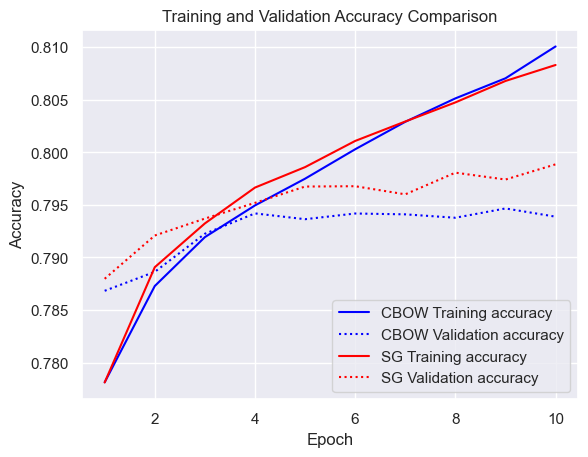

In [61]:
#Plot accuracy for both models and compare
sns.set()
acc_CBOW = hist_CBOW.history['accuracy']
val_CBOW = hist_CBOW.history['val_accuracy']
acc_SG = hist_SG.history['accuracy']
val_SG = hist_SG.history['val_accuracy']
epochs = range(1, len(acc_CBOW) + 1)

plt.plot(epochs, acc_CBOW, '-', color='blue',label='CBOW Training accuracy')
plt.plot(epochs, val_CBOW, ':', color='blue', label='CBOW Validation accuracy')
plt.plot(epochs, acc_SG, '-', color='red', label='SG Training accuracy')
plt.plot(epochs, val_SG, ':', color='red', label='SG Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [63]:
#We can see overfitting let us add some dropout to prevent it
model_drp_CBOW = Sequential()
model_drp_CBOW.add(Dense(512, activation='relu', input_dim=100))
model_drp_CBOW.add(Dropout(0.25))
model_drp_CBOW.add(Dense(256, activation='relu'))
model_drp_CBOW.add(Dense(1, activation='sigmoid'))
model_drp_CBOW.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
#Fit the model to CBOW encoding
hist_CBOW_drp = model_drp_CBOW.fit(CBOW_train_x, CBOW_train_y['target'], validation_data=(CBOW_valid_x, CBOW_valid_y['target']), epochs=10, batch_size=100)

Epoch 1/10
7282/7282 [==============================] - 92s 13ms/step - loss: 0.4780 - accuracy: 0.7697 - val_loss: 0.4566 - val_accuracy: 0.7821
Epoch 2/10
7282/7282 [==============================] - 142s 19ms/step - loss: 0.4634 - accuracy: 0.7790 - val_loss: 0.4549 - val_accuracy: 0.7861
Epoch 3/10
7282/7282 [==============================] - 188s 26ms/step - loss: 0.4585 - accuracy: 0.7817 - val_loss: 0.4498 - val_accuracy: 0.7876
Epoch 4/10
7282/7282 [==============================] - 211s 29ms/step - loss: 0.4552 - accuracy: 0.7838 - val_loss: 0.4469 - val_accuracy: 0.7893
Epoch 5/10
7282/7282 [==============================] - 104s 14ms/step - loss: 0.4527 - accuracy: 0.7853 - val_loss: 0.4456 - val_accuracy: 0.7908
Epoch 6/10
7282/7282 [==============================] - 128s 18ms/step - loss: 0.4501 - accuracy: 0.7868 - val_loss: 0.4444 - val_accuracy: 0.7919
Epoch 7/10
7282/7282 [==============================] - 131s 18ms/step - loss: 0.4488 - accuracy: 0.7878 - val_loss: 0.

In [ ]:
#We can see overfitting let us add some dropout to prevent it
model_drp_SG = Sequential()
model_drp_SG.add(Dense(512, activation='relu', input_dim=100))
model_drp_SG.add(Dropout(0.25))
model_drp_SG.add(Dense(256, activation='relu'))
model_drp_SG.add(Dense(1, activation='sigmoid'))
model_drp_SG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
#Fit the model to SG encoding
hist_SG_drp = model_drp_SG.fit(SG_train_x, SG_train_y['target'], validation_data=(SG_valid_x, SG_valid_y['target']), epochs=10, batch_size=100)

Epoch 1/10
7282/7282 [==============================] - 80s 11ms/step - loss: 0.4688 - accuracy: 0.7746 - val_loss: 0.4547 - val_accuracy: 0.7837
Epoch 2/10
7282/7282 [==============================] - 96s 13ms/step - loss: 0.4539 - accuracy: 0.7850 - val_loss: 0.4434 - val_accuracy: 0.7907
Epoch 3/10
7282/7282 [==============================] - 93s 13ms/step - loss: 0.4479 - accuracy: 0.7881 - val_loss: 0.4404 - val_accuracy: 0.7917
Epoch 4/10
7282/7282 [==============================] - 98s 13ms/step - loss: 0.4440 - accuracy: 0.7902 - val_loss: 0.4421 - val_accuracy: 0.7915
Epoch 5/10
7282/7282 [==============================] - 109s 15ms/step - loss: 0.4408 - accuracy: 0.7916 - val_loss: 0.4355 - val_accuracy: 0.7950
Epoch 6/10
7282/7282 [==============================] - 121s 17ms/step - loss: 0.4384 - accuracy: 0.7928 - val_loss: 0.4350 - val_accuracy: 0.7938
Epoch 7/10
7282/7282 [==============================] - 117s 16ms/step - loss: 0.4361 - accuracy: 0.7941 - val_loss: 0.433

In [ ]:
#Plot accuracy for both models and compare
sns.set()
acc_CBOW = hist_CBOW_drp.history['accuracy']
val_CBOW = hist_CBOW_drp.history['val_accuracy']
acc_SG = hist_SG_drp.history['accuracy']
val_SG = hist_SG_drp.history['val_accuracy']
epochs = range(1, len(acc_CBOW) + 1)

plt.plot(epochs, acc_CBOW, '-', color='blue',label='CBOW Training accuracy')
plt.plot(epochs, val_CBOW, ':', color='blue', label='CBOW Validation accuracy')
plt.plot(epochs, acc_SG, '-', color='red', label='SG Training accuracy')
plt.plot(epochs, val_SG, ':', color='red', label='SG Validation accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()